In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import pickle

In [91]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim=1024, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(hidden_dim,hidden_dim),nn.BatchNorm1d(hidden_dim),nn.ReLU(),nn.Dropout(p=dropout))
        self.layer2 = nn.Sequential(nn.Linear(hidden_dim,hidden_dim),nn.BatchNorm1d(hidden_dim),nn.ReLU(),nn.Dropout(p=dropout))
        
    def forward(self,x):
        return x+self.layer2(self.layer1(x))

class LiftModel(nn.Module):
    def __init__(self,n_blocks=2, hidden_layer=1024, dropout=0.5, output_nodes=15*3):
        super(LiftModel, self).__init__()
        input_nodes = int(output_nodes*2/3)
        self.input_map = nn.Linear(input_nodes,hidden_layer)
        self.output_map = nn.Linear(hidden_layer,output_nodes)
        self.blocks = []
        for _ in range(n_blocks):
            self.blocks.append(ResidualBlock(hidden_layer,dropout))
        self.blocks = nn.ModuleList(self.blocks)
        

    def forward(self,poses):
        poses = self.input_map(poses.view(poses.shape[0],-1))
        for block in self.blocks:
            poses = block(poses)
        poses = self.output_map(poses).view(poses.shape[0],-1,3)
        return poses
    
def cal_mpjpe(pose_1, pose_2, avg=True):
    n_joints = pose_1.shape[1]
    batch_size = pose_1.shape[0]
    diff = pose_1-pose_2
    diff_sq = diff ** 2
    dist_per_joint = torch.sqrt(torch.sum(diff_sq, axis=2))
    dist_per_sample = torch.mean(dist_per_joint, axis=1)
    if avg is True:
        dist_avg = torch.mean(dist_per_sample)
    else:
        dist_avg = dist_per_sample
    return dist_avg

class myDatasetWeak(torch.utils.data.Dataset):
    def __init__(self,data_in1,data_in2,data_rot,data_trans):
        self.inputs1 = data_in1
        self.inputs2 = data_in2
        self.rot = data_rot
        self.trans = data_trans
    def __getitem__(self,index):
        return torch.FloatTensor(self.inputs1[index]),torch.FloatTensor(self.inputs2[index]),torch.FloatTensor(self.rot[index]),torch.FloatTensor(self.trans[index])
    def __len__(self):
        return self.inputs1.shape[0]
    
class myDataset(torch.utils.data.Dataset):
    def __init__(self,data_in,data_out):
        self.inputs = data_in
        self.outputs = data_out
    def __getitem__(self,index):
        return torch.FloatTensor(self.inputs[index]),torch.FloatTensor(self.outputs[index])
    def __len__(self):
        return self.inputs.shape[0]
    
    
def transform(view1,trans,rot):
    view1 = torch.matmul(rot.view(rot.shape[0],1,3,3),view1[:,:,:,None])[:,:,:,0]
    view1 = view1+trans[:,None,:]
    return view1

# def transform(view1,trans,rot):
#     view1 = torch.matmul(rot.view(rot.shape[0],1,3,3),view1[:,:,:,None])[:,:,:,0]
#     view1 = view1+trans[:,None,:]
#     temp = view1[:,:,:2]/view1[:,:,2:3]
#     temp[:,:,0] = temp[:,:,0] * 1.1491407 
#     temp[:,:,1] = temp[:,:,1] * 1.148799
#     return temp


mseLoss = torch.nn.MSELoss()

In [3]:
data_loc = '/mnt/infonas/data/pbansal/data_train.pkl'
filepath = 'checkpoint.pt'
#device = torch.device('cpu')
device = torch.device('cuda:0')

In [6]:
with open(data_loc,'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['joint_2d_1', 'joint_2d_2', 'joint_3d', 'rot', 'transl', 'focal_len_1', 'focal_len_2'])

In [60]:
print(data['focal_len_2'][0],data['focal_len_1'][0])

[1.1491407 1.148799 ] [1.1496756 1.1475917]


In [95]:
def run_epoch_weak(epoch_no, data_in1, data_in2, data_rot, data_trans, model,device, optimiser, batch_size=256,split='train'):
    train_set = myDatasetWeak(data_in1,data_in2,data_rot,data_trans)
    train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size,drop_last = False,shuffle=True)
    total_loss,count = 0,0
    for x1,x2,rot,trans in train_loader:
        y_pred1 = model(x1.to(device))

#         x2_other = transform(y_pred1,trans.to(device),rot.to(device))
#         loss = cal_mpjpe(x2.to(device),x2_other)

        y_pred2 = model(x2.to(device))
        y_pred_other = transform(y_pred1,trans.to(device),rot.to(device))
        loss = cal_mpjpe(y_pred2,y_pred_other)

        if (split=='train'):
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        count += x1.shape[0]
        total_loss += float(loss.detach().cpu())*x1.shape[0]
    return float(total_loss/count)

def run_epoch(epoch_no, data_in,data_out, model,device, optimiser, batch_size=256,split='train'):
    train_set = myDataset(data_in,data_out)
    train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size,drop_last = False,shuffle=True)
    total_loss,count = 0,0
    for x,y in train_loader:
        y_pred = model(x.to(device))
        loss = cal_mpjpe(y_pred,y.to(device))
        if (split=='train'):
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        count += x.shape[0]
        total_loss += float(loss.detach().cpu())*x.shape[0]
    return float(total_loss/count)


torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)


model = LiftModel(n_blocks=2).to(device)

lr = 1e-3
optim = torch.optim.Adam(list(model.parameters()),lr=lr)
max_epoch = 50
with open(data_loc,'rb') as f:
    data = pickle.load(f)
    
num_examples = data['joint_2d_1'].shape[0]
train_input1 = data['joint_2d_1'][:-int(num_examples/10)]
train_input2 = data['joint_2d_2'][:-int(num_examples/10)]
train_rot = data['rot'][:-int(num_examples/10)]
train_trans = data['transl'][:-int(num_examples/10)]

val_input = data['joint_2d_1'][-int(num_examples/10):]
val_output = data['joint_3d'][-int(num_examples/10):]

train_losses,val_losses = [],[]
for epoch_no in range(max_epoch):
    with torch.no_grad():
        val_loss = run_epoch(epoch_no, val_input,val_output,model, device,optim, batch_size=64,split='val')
    train_loss = run_epoch_weak(epoch_no, train_input1,train_input2,train_rot,train_trans,model, device,optim, batch_size=64)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print (epoch_no,train_loss,val_loss)

0 0.23636459899300732 1.7292976083051603
1 0.0815780761487169 0.47594453153825306
2 0.05503313710473063 0.4668925991124339
3 0.030619660863878777 0.4652191651197411
4 0.01632529426836346 0.46444898744475105
5 0.010735938418957557 0.4648661979463148
6 0.007893939106814983 0.4614583626427692
7 0.005832487576259203 0.4641780027330136
8 0.005774959524013101 0.463216705972387
9 0.0048731507122389455 0.46279771556492527


KeyboardInterrupt: 

In [84]:
torch.save(model.state_dict(), filepath)

In [85]:
block3val = val_losses
block3train = train_losses
# block2val = val_losses
# block2train = train_losses

In [79]:
val_losses

[2.0532939864207025,
 0.5231856785939939,
 0.5125416764413804,
 0.49665446691730586,
 0.47762628688621617,
 0.466597753769309,
 0.46329558236302015,
 0.4647335494896621,
 0.46345354421880536,
 0.4625453202465386,
 0.460871961088073,
 0.46270480857391594,
 0.464781715923673,
 0.4697377879701475,
 0.46774978429338737,
 0.46642335206041086]

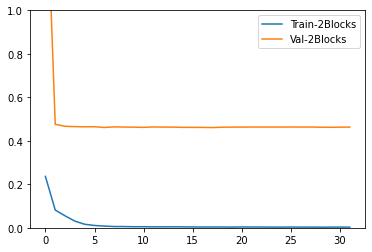

In [86]:
plt.ylim(0,1)
# plt.plot(block2train)
# plt.plot(block2val)
plt.plot(block3train)
plt.plot(block3val)
plt.legend(['Train-2Blocks','Val-2Blocks','Train-3Blocks','Val-3Blocks'])